In [1]:
import numpy as np
import torch
from math import ceil, comb

import quairkit as qkit
from quairkit import Circuit, Hamiltonian, to_state
from quairkit.database import *
from quairkit.qinfo import *

qkit.set_dtype('complex128')

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from qite import afm_random_jump, to_liouville, algorithm2, model_ding2024simulating, model_peng2025quantum, model_yu2025lindbladian, model_huang2025robust

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FuncFormatter

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family
plt.rcParams["font.size"] = 15

Since this part involve random generation of jump operators, we fix one seed to reproduce our plot data (so that pre-computed QSP angles can be directly load). One can uncomment this line to obtain a different but similar result.

In [4]:
qkit.set_seed(20250828)
qkit.get_seed()

20250828

## Experiment setting

In [5]:
num_qubits = 4
rho0 = zero_state(num_qubits)

t = 20

prepare AFM Heisenberg model and random jump operators, where the number of jump operators equals to the number of qubits.

In [6]:
num_trials = 5
list_afm_model = [to_liouville(*afm_random_jump(num_qubits)) for _ in range(num_trials)]

def afm_trial(num_step: int):
    r"""A trial experiment to run Lindbladian simulation algorithm
    
    Returns:
        The error and overall success probability of the simulation.
    """
    list_error, list_cost = [], []
    for Hc, H in list_afm_model:
        error, resource_cost = algorithm2(t, num_step, rho0, Hc, H)
        list_error.append(error)
        list_cost.append(resource_cost)
    
    list_error, list_cost = np.log10(np.array(list_error)), np.log10(np.array(list_cost).astype(float))
    return np.mean(list_error), np.mean(list_cost), np.std(list_error), np.std(list_cost)

## Set sample step

In [7]:
max_num_sample = 50

max_N = max(ceil(t ** 3), 1)
list_N = np.unique(np.rint(np.geomspace(2 * t, max_N, num=max_num_sample - 3)).astype(int)).tolist()

meaningful_N = [ceil(2 * t), ceil(t ** 2)]
list_N += meaningful_N

final_arr = np.unique(list_N + meaningful_N)
idx_in_order = np.searchsorted(final_arr, meaningful_N) 
idx_map = dict(zip(map(int, meaningful_N), map(int, idx_in_order)))
list_N = final_arr.tolist()

## Compute data

In [8]:
list_afm_error_mean, list_afm_cost_mean = [], []
list_afm_error_std = []

for N in list_N:
    afm_error_mean, afm_cost_mean, afm_error_std, _ = afm_trial(N)
    list_afm_error_mean.append(afm_error_mean)
    list_afm_cost_mean.append(afm_cost_mean)
    list_afm_error_std.append(afm_error_std)

Computations of angles for QPP are completed with mean error 1.4619645679035523e-06
Computations of angles for QPP are completed with mean error 1.1945975323808554e-06
Computations of angles for QPP are completed with mean error 1.2913488741344365e-06
Computations of angles for QPP are completed with mean error 1.2758767492681403e-06
Computations of angles for QPP are completed with mean error 1.2340513762009994e-06
Computations of angles for QPP are completed with mean error 1.2736781608539614e-06
Computations of angles for QPP are completed with mean error 1.0600252660645227e-06
Computations of angles for QPP are completed with mean error 1.0552044653095663e-06
Computations of angles for QPP are completed with mean error 1.1255113093108695e-06
Computations of angles for QPP are completed with mean error 1.0182877747744555e-06
Computations of angles for QPP are completed with mean error 1.0655065866969122e-06
Computations of angles for QPP are completed with mean error 8.8956073265760

save data

In [9]:
np.save('data/figure3c_data.npy', [list_N, list_afm_error_mean, list_afm_cost_mean, list_afm_error_std])

## Plot

In [10]:
list_N, list_afm_error_mean, list_afm_cost_mean, list_afm_error_std = np.load('data/figure3c_data.npy')

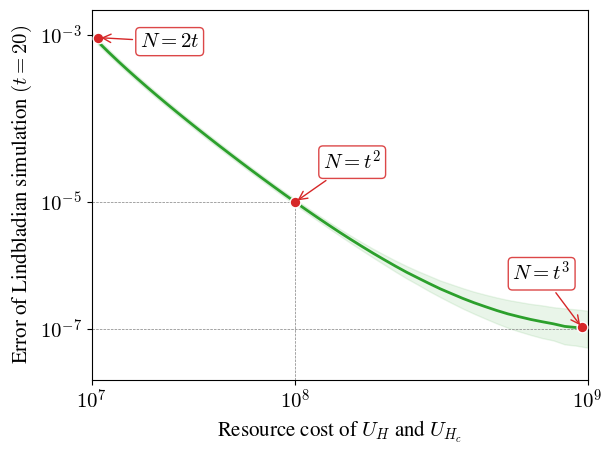

In [11]:
data = sorted(zip(list_N, 
                  list_afm_cost_mean, list_afm_error_mean, list_afm_error_std), key=lambda x: x[0])
N, afm_cost_mean, afm_error_mean, afm_error_std = [np.array(v) for v in zip(*data)]

c1 = 'C2'
c2 = 'C3'

plt.plot(afm_cost_mean, afm_error_mean, color=c1, lw=2)
plt.fill_between(afm_cost_mean, list_afm_error_mean - afm_error_std, afm_error_mean + afm_error_std, color=c1, alpha=0.1)


x_2t, y_2t = afm_cost_mean[0], afm_error_mean[0]
x_t2, y_t2 = afm_cost_mean[20], afm_error_mean[20]
x_t3, y_t3 = afm_cost_mean[-1], afm_error_mean[-1]

plt.hlines(y=y_t2, xmin=x_2t, xmax=x_t2, colors='grey', linestyles='dashed', lw=0.5)
plt.vlines(x=x_t2, ymin=y_t3-0.6, ymax=y_t2, colors='grey', linestyles='dashed', lw=0.5)
plt.hlines(y=y_t3, xmin=x_2t, xmax=x_t3, colors='grey', linestyles='dashed', lw=0.5)

ax = plt.gca()
ax.scatter([x_2t+0.03, x_t2, x_t3-0.025], [y_2t-0.03, y_t2, y_t3+0.02], s=60, color=c2, edgecolor='white', zorder=5)

# place text nearby with an arrow
ax.annotate(
    r'$N = 2t$',
    xy=(x_2t+0.03, y_2t-0.03),                 # point to annotate
    xytext=(30, -10),             # offset in points
    textcoords='offset points',
    ha='left', va='bottom',
    bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=c2, alpha=0.85),
    arrowprops=dict(arrowstyle='->', color=c2, lw=1),
    zorder=6,
)
ax.annotate(
    r'$N = t^2$',
    xy=(x_t2, y_t2),                 # point to annotate
    xytext=(20, 20),             # offset in points
    textcoords='offset points',
    ha='left', va='bottom',
    bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=c2, alpha=0.85),
    arrowprops=dict(arrowstyle='->', color=c2, lw=1),
    zorder=6,
)
ax.annotate(
    r'$N = t^3$',
    xy=(x_t3-0.025, y_t3+0.02),                 # point to annotate
    xytext=(-50, 30),             # offset in points
    textcoords='offset points',
    ha='left', va='bottom',
    bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=c2, alpha=0.85),
    arrowprops=dict(arrowstyle='->', color=c2, lw=1),
    zorder=6,
)

plt.xlim(x_2t, x_t3)
plt.ylim(y_t3-0.6, y_2t+0.3)

plt.xticks([x_2t, x_t2, x_t3], labels=[r'$10^{' + f'{tick:,.0f}' + r'}$' for tick in [x_2t, x_t2, x_t3]])
plt.yticks([y_2t, y_t2, y_t3], labels=[r'$10^{' + f'{tick:,.0f}' + r'}$' for tick in [y_2t, y_t2, y_t3]])

plt.xlabel(r'Resource cost of $U_H$ and $U_{H_c}$')
plt.ylabel(r'Error of Lindbladian simulation $(t = 20)$')

plt.show()

---

In [12]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.3
torch: 2.9.1+cu128
torch cuda: 12.8
numpy: 2.3.5
scipy: 1.16.3
matplotlib: 3.10.7
---------SYSTEM---------
Python version: 3.14.0
OS: Linux
OS version: #88-Ubuntu SMP PREEMPT_DYNAMIC Sat Oct 11 09:28:41 UTC 2025
---------DEVICE---------
CPU:  AMD EPYC 9554 64-Core Processor
GPU: (0) NVIDIA GeForce RTX 3090
     (0) NVIDIA GeForce RTX 3090
